In [42]:
import numpy as np
import random
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
import quantstats as qs
import pandas as pd

In [43]:
device = 'mps'

In [44]:
from stable_baselines3 import PPO
import gymnasium as gym 

df = gym_anytrading.datasets.STOCKS_GOOGL.copy()

window_size = 10
start_index = 1800
end_index = 2150


def make_stock_env(start_index=start_index, end_index=end_index, window_size=window_size):
    return gym.make(
    'stocks-v0',
    df=STOCKS_GOOGL,
    window_size=window_size,
    frame_bound=(start_index, end_index)
)

In [45]:
env = make_stock_env(start_index, end_index, window_size)
print("observation_space:", env.observation_space)


observation_space: Box(-10000000000.0, 10000000000.0, (10, 2), float32)


In [46]:
model_name = 'stocks'

In [47]:
train = True
save = False

if train:
    # Instantiate the agent
    model = PPO(
        "MlpPolicy",
        env,
        n_steps=1024,
        batch_size=64,
        n_epochs=4,
        gamma=0.999,
        gae_lambda=0.98,
        ent_coef=0.01,
        verbose=10,
        device=device
    )

    # Train the agent
    steps = 2e3
    model.learn(total_timesteps=steps, progress_bar=True)
    if save:
        model.save(model_name)

Output()

Using mps device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 349      |
|    ep_rew_mean     | 144      |
| time/              |          |
|    fps             | 200      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 1024     |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 349         |
|    ep_rew_mean          | 149         |
| time/                   |             |
|    fps                  | 193         |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.017776987 |
|    clip_fraction        | 0.0337      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_variance   | 3.07e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 383         |
|    n_updates            | 4           |
|    policy_gradient_loss | -0.00353    |
|    value_loss           | 734         |
-----------------------------------------


In [48]:
def print_results(model):
    eval_env = Monitor(make_stock_env())
    mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10)
    print(f"mean_reward= {mean_reward} +/- {std_reward}", end="\r")

In [49]:
# model = PPO.load(model_name,device=device)

In [50]:
print_results(model)

In [51]:
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

observation, info = env.reset(seed=2023)

while True:
    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)

action_stats: {<Actions.Sell: 0>: 122, <Actions.Buy: 1>: 227}
info: {'total_reward': 130.7696533203125, 'total_profit': 0.35484522518732164, 'position': <Positions.Long: 1>}


In [52]:
env.unwrapped.__dict__.keys()

dict_keys(['frame_bound', 'render_mode', 'df', 'window_size', 'prices', 'signal_features', 'shape', 'action_space', 'observation_space', '_start_tick', '_end_tick', '_truncated', '_current_tick', '_last_trade_tick', '_position', '_position_history', '_total_reward', '_total_profit', '_first_rendering', 'history', 'trade_fee_bid_percent', 'trade_fee_ask_percent', 'spec', '_np_random'])

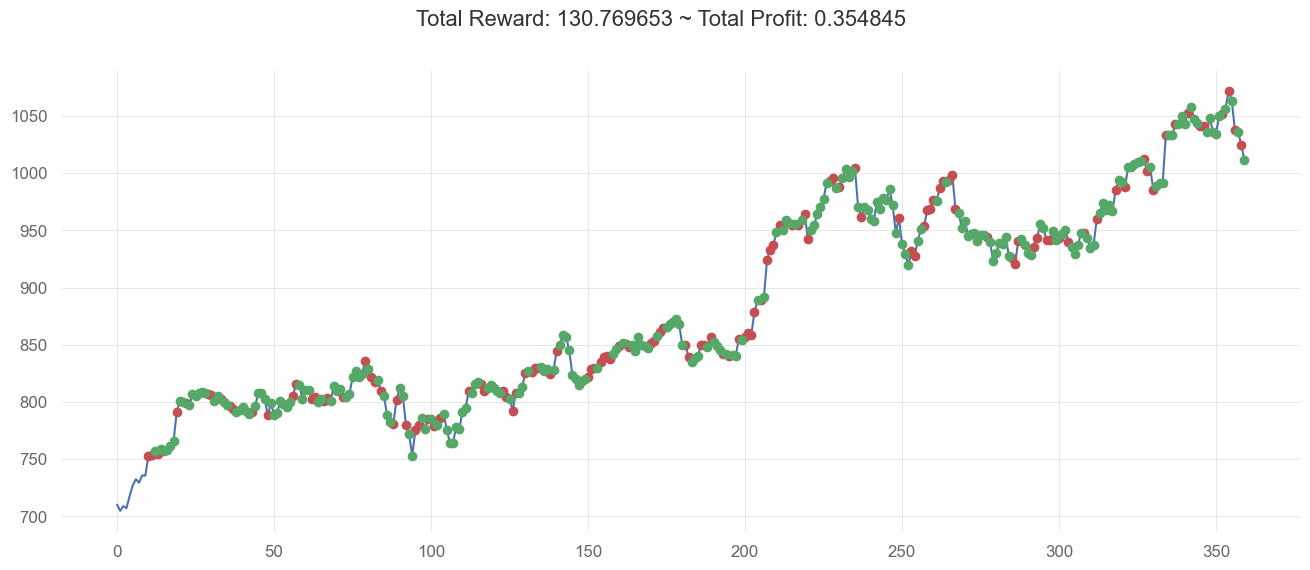

In [53]:
plt.figure(figsize=(16, 6))
env.unwrapped.render_all()
plt.show()

In [54]:
print("env information:")
print("> shape:", env.unwrapped.shape)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())

print()
print("env information:")
print("> shape:", env.unwrapped.shape)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())

env information:
> shape: (10, 2)
> df.shape: (2335, 6)
> prices.shape: (360,)
> signal_features.shape: (360, 2)
> max_possible_profit: 4.111612345774734

env information:
> shape: (10, 2)
> df.shape: (2335, 6)
> prices.shape: (360,)
> signal_features.shape: (360, 2)
> max_possible_profit: 4.111612345774734


In [55]:
import warnings 
warnings.filterwarnings(action='ignore',category=FutureWarning)

In [56]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.html(returns, output='SB3_a2c_quantstats.html')

In [57]:
start_with = 1000
end_with = round(start_with * net_worth[-1],4)
print(f"If you invested {start_with} dollars, you'd have {end_with} dollars now")

If you invested 1000 dollars, you'd have 354.8452 dollars now


In [58]:
from IPython.display import display, HTML

with open('SB3_a2c_quantstats.html','r') as f:
    display(HTML(f.read()))